In [70]:
# Import statements
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import unicodedata
import string
import random

import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.nn.functional as fxnl
import torchtext as t_text


In [71]:
# Building and training a basic character level RNN to classifiy words
# Prepare the Data

def find_files(path): return glob.glob(path)
print(find_files("dataset/names/*.txt"))

['dataset/names\\Arabic.txt', 'dataset/names\\Chinese.txt', 'dataset/names\\Czech.txt', 'dataset/names\\Dutch.txt', 'dataset/names\\English.txt', 'dataset/names\\French.txt', 'dataset/names\\German.txt', 'dataset/names\\Greek.txt', 'dataset/names\\Irish.txt', 'dataset/names\\Italian.txt', 'dataset/names\\Japanese.txt', 'dataset/names\\Korean.txt', 'dataset/names\\Polish.txt', 'dataset/names\\Portuguese.txt', 'dataset/names\\Russian.txt', 'dataset/names\\Scottish.txt', 'dataset/names\\Spanish.txt', 'dataset/names\\Vietnamese.txt']


In [72]:
# Helper Methods for converting unicode chars to plain ASCII

all_letters = string.ascii_letters + " .,;'"
num_letters = len(all_letters)

def unicode_to_ascii(unicode_string):
    return ''.join(char for char in unicodedata.normalize('NFD', unicode_string) if unicodedata.category(char) != 'Mn' and char in all_letters)

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [73]:
category_lines = {}
all_categories = []

def read_lines(file_name):
    lines = open(file_name, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]


for file_name in find_files("dataset/names/*.txt"):
    category = os.path.splitext(os.path.basename(file_name))[0]
    all_categories.append(category)
    lines = read_lines(file_name)
    category_lines[category] = lines

num_categories = len(all_categories) ## Classes

In [74]:
print(category_lines['Italian'][:15])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni', 'Abatescianni', 'Abba', 'Abbadelli', 'Abbascia', 'Abbatangelo', 'Abbatantuono', 'Abbate', 'Abbatelli', 'Abbaticchio', 'Abbiati']


In [75]:
print(all_categories)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


In [76]:
print(all_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [77]:
# Turning names to a Tensor

def letter_to_index(letter):
    return all_letters.find(letter)

def letter_to_tensor(letter):
    letter_tensor = torch.zeros(1, num_letters)
    letter_tensor[0][letter_to_index(letter)] = 1
    return letter_tensor

def line_to_tensor(line):
    line_tensor = torch.zeros(len(line), 1, num_letters)
    for li, letter in enumerate(line):
        line_tensor[li][0][letter_to_index(letter)] = 1
    return line_tensor


In [78]:
print(len(all_letters))

57


In [79]:
print(letter_to_tensor('J'), letter_to_tensor('J').size())
print('-' * 89)
print(line_to_tensor('Jones').size())
print('-' * 89)
print(line_to_tensor('Jones'))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]]) torch.Size([1, 57])
-----------------------------------------------------------------------------------------
torch.Size([5, 1, 57])
-----------------------------------------------------------------------------------------
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

In [80]:
# Creating the Network

class RNNet(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNNet, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    

In [81]:
print(num_letters, num_categories)

57 18


In [82]:
num_hidden = 128
gpu_device = torch.device("cuda:0")
rnn = RNNet(num_letters, num_hidden, num_categories)#.to(gpu_device)

In [83]:
samp_input = letter_to_tensor("A")
samp_hidden = torch.zeros(1, num_hidden)
samp_output, samp_nxt_hidden = rnn(samp_input, samp_hidden)

print("Input", samp_input)
print("-" * 89)
print("Hidden", samp_hidden)
print("-" * 89)
print("Output", samp_output)
print("-" * 89)
print("Next Hidden", samp_nxt_hidden)

Input tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
-----------------------------------------------------------------------------------------
Hidden tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])
---------------------------------------------------------------

In [84]:
sample_input = line_to_tensor('Albert')#.to(gpu_device)
sample_hidden = torch.zeros(1, num_hidden)#.to(gpu_device)

sample_output, next_sample_hidden = rnn(sample_input[0], sample_hidden)
print(sample_output)
print('-' * 89)
print(next_sample_hidden)
print('-' * 89)
for p in rnn.parameters():
    print(p.grad)

tensor([[-2.9532, -2.8056, -2.9316, -2.8157, -3.0052, -2.8369, -2.7928, -2.8975,
         -2.9713, -2.8612, -2.9703, -2.9017, -2.9192, -2.8991, -2.9542, -2.8542,
         -2.8077, -2.8849]], grad_fn=<LogSoftmaxBackward>)
-----------------------------------------------------------------------------------------
tensor([[ 0.0810, -0.1188, -0.0517,  0.0075,  0.1227, -0.0292,  0.0275, -0.0023,
          0.0282, -0.1144, -0.0138,  0.0133, -0.0870, -0.0830, -0.0091,  0.0212,
          0.0701,  0.0158,  0.0518, -0.0636,  0.1141,  0.0150, -0.0268,  0.0425,
         -0.0701, -0.0241, -0.0456,  0.1015,  0.0312,  0.0800, -0.0475,  0.1103,
         -0.0135, -0.0573, -0.0089, -0.0320,  0.0142,  0.0008,  0.0923, -0.1118,
         -0.0562, -0.0300,  0.0698, -0.0089, -0.0594, -0.1072,  0.0250, -0.0185,
         -0.0488,  0.0217,  0.0828,  0.0057, -0.0217,  0.0408, -0.0751, -0.1193,
         -0.0179, -0.0552, -0.0414, -0.0014, -0.0311,  0.0250, -0.0121,  0.0383,
          0.1007,  0.0227,  0.1118,  0.01

In [85]:
# Training

def category_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


In [86]:
print(category_from_output(sample_output))

('German', 6)


In [87]:
def random_choice(l):
    return l[random.randint(0, len(l) - 1)]

def random_training_example():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

for idx in range(10):
    category, line, category_tensor, line_tensor = random_training_example()
    print('Category =', category, '/ line =', line)



Category = Czech / line = Schmeiser
Category = Spanish / line = Palomo
Category = Dutch / line = Meeuwis
Category = Irish / line = Cassidy
Category = Chinese / line = Xin
Category = Scottish / line = White
Category = Chinese / line = Huang
Category = French / line = Abel
Category = English / line = Dickson
Category = French / line = Charron


In [88]:
# Training the network
loss_function = nn.NLLLoss()
learning_rate = 0.005


In [89]:
for p in rnn.parameters():
    print(p.grad)

None
None
None
None


In [90]:
# Training method
def train(category_tensor, line_tensor):
    hidden_tensor = rnn.init_hidden()#.to(gpu_device)
   
   
    rnn.zero_grad()

   
    for idx in range(line_tensor.size()[0]):
        output_tensor, next_hidden_tensor = rnn(line_tensor[idx], hidden_tensor)
    
    loss = loss_function(output_tensor, category_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        #print(p.grad)
        #break
        if p.grad is not None:
            p.data.add_(-learning_rate, p.grad.data)
    
    return output_tensor, loss.item()

In [91]:
n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_example()
  
    output, loss = train(category_tensor, line_tensor)
    #break
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.9520 Antwerp / Irish ✗ (Dutch)
10000 10% (0m 15s) 2.4868 Jong / Korean ✓
15000 15% (0m 23s) 2.6279 Glaisyer / German ✗ (French)
20000 20% (0m 33s) 2.6745 Johnstone / French ✗ (Scottish)
25000 25% (0m 41s) 1.9525 Simon / Irish ✓
30000 30% (0m 52s) 2.8017 Andel / Czech ✗ (Dutch)
35000 35% (1m 0s) 1.4417 Mikolajczak / Polish ✓
40000 40% (1m 8s) 2.4849 Smeets / Greek ✗ (Dutch)
45000 45% (1m 17s) 1.7931 Sault / French ✓
50000 50% (1m 33s) 2.1046 Mendes / Greek ✗ (Portuguese)
55000 55% (1m 56s) 1.4841 Kinugasa / Japanese ✓
60000 60% (2m 17s) 3.8626 Jonas / Greek ✗ (Czech)
65000 65% (2m 44s) 2.4262 Ibbotson / Irish ✗ (English)
70000 70% (3m 4s) 2.2659 Antar / German ✗ (Arabic)
75000 75% (3m 29s) 0.8993 Louverdis / Greek ✓
80000 80% (3m 59s) 1.3257 Tresler / German ✓
85000 85% (4m 22s) 2.5520 Nairn / Irish ✗ (English)
90000 90% (4m 46s) 1.2715 Kistler / German ✓
95000 95% (5m 8s) 2.2348 Slocombe / French ✗ (English)
100000 100% (5m 31s) 1.9529 Elizondo / Portuguese ✗ (Spanish

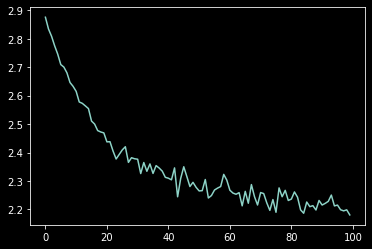

In [92]:
plt.figure()
plt.plot(all_losses)

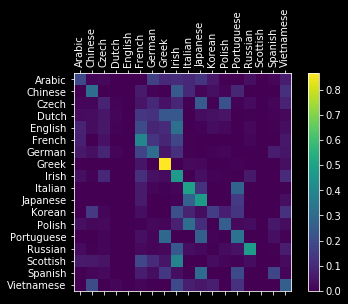

In [98]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(num_categories, num_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(num_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [100]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(line_to_tensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-1.93) Russian
(-1.94) Irish
(-2.06) Scottish

> Jackson
(-1.79) Irish
(-2.10) Scottish
(-2.27) Dutch

> Satoshi
(-1.18) Italian
(-1.70) Polish
(-1.88) Japanese
